# HW2 - Q1


## Initialization

In [ ]:
import torch
import matplotlib
import torchvision
import numpy as np
from math import sqrt
from tqdm import tqdm
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor
from torchvision.datasets import FashionMNIST
%matplotlib inline

initialize variables

In [ ]:
learning_rate = 0.001
batch_size = 8
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device = torch.device('cpu')

## Data

In [ ]:
train_dataset = FashionMNIST(root='/', train=True, download=True, transform=ToTensor())
test_dataset = FashionMNIST(root='/', train=False, download=True, transform=ToTensor())

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

show sample images from dataset

---------------------------- class:  0


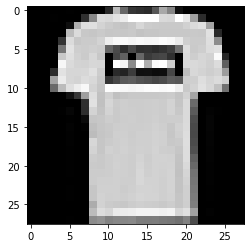

---------------------------- class:  1


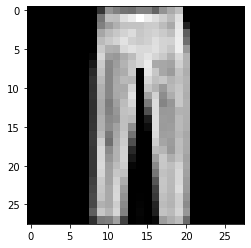

---------------------------- class:  2


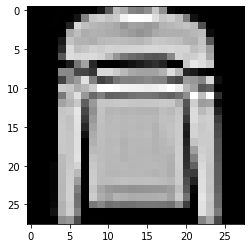

---------------------------- class:  3


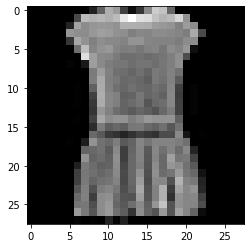

---------------------------- class:  4


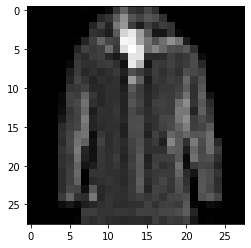

---------------------------- class:  5


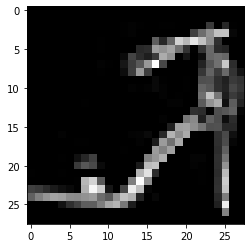

---------------------------- class:  6


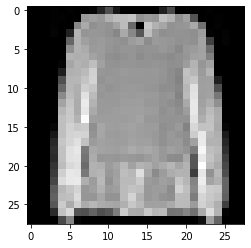

---------------------------- class:  7


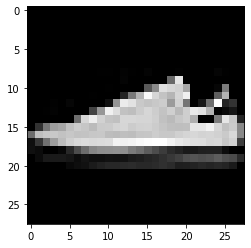

---------------------------- class:  8


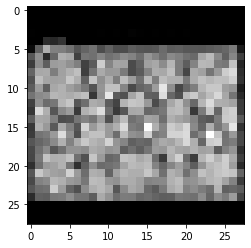

---------------------------- class:  9


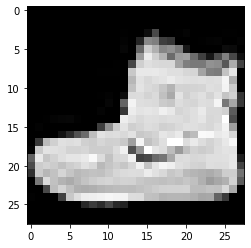

In [ ]:
for i in range(10):
    print('---------------------------- class: ', i)
    sample = train_dataset.data[train_dataset.targets == i][0]
    plt.imshow(sample.squeeze(0), cmap='gray')
    plt.show()

## Define Layers

In [ ]:
class Network:
    def gradient_step(self):
        pass
    def zero_grad(self):
        pass
    def __call__(self, *args, **kwargs):
        return self.forward(*args, **kwargs)

class LinearLayer(Network):
    def __init__(self, input, output):
        self.input = input
        self.output = output

        # self.W = torch.zeros((output,input), requires_grad=True)
        W_np = np.random.uniform(-1/sqrt(self.input),1/sqrt(self.input),(output,input)).astype(np.float32)
        self.W = torch.tensor(W_np, requires_grad = True).to(device)
        # self.W = torch.rand((output,input), requires_grad=True).data.normal_(0, 0.0001)
        # self.W.requires_grad = True
        
        # self.b = torch.zeros(output, requires_grad=True)
        b_np = np.random.uniform(-1/sqrt(self.input),1/sqrt(self.input),output).astype(np.float32)
        self.b = torch.tensor(b_np, requires_grad = True).to(device)
        # self.b = torch.rand(output, requires_grad=True).data.normal_(0, 0.0001)
        # self.b.requires_grad = True
    
    def forward(self, x):
        x = torch.matmul(x, self.W.T)
        x += self.b
        return x

    def gradient_step(self):
        self.W.data.sub_(learning_rate * self.W.grad.data)
        self.b.data.sub_(learning_rate * self.b.grad.data)
    
    def zero_grad(self):
        self.W.grad = None
        self.b.grad = None

class ReLU(Network):
    def forward(self, xb):
        xb = torch.maximum(xb, torch.tensor(0))
        return xb

## Loss

In [ ]:
def CrossEntropyLoss(xb, yb):
    xb = xb.exp()
    xb = xb / xb.sum(axis=-1).unsqueeze(-1)
    loss = -xb.gather(1, yb.view(-1,1)).log().sum()
    return loss


## Model

In [ ]:
class FullyConnectedNetwork(Network):
    def __init__(self, features_size):
        self.layers = []
        for i in range(len(features_size)-1):
            self.layers.append(LinearLayer(features_size[i], features_size[i+1]))
            self.layers.append(ReLU())

    def forward(self, xb, yb):
        for l in self.layers:
              xb = l(xb)
        loss = CrossEntropyLoss(xb, yb)
        return xb, loss
    
    def gradient_step(self):
        for l in self.layers:
            l.gradient_step()


    def zero_grad(self):
        for l in self.layers:
            l.zero_grad()

## Evaluation

In [ ]:
def evaluate(model, dataloader):
    total_loss = 0 
    correct_guess = 0
    for xb, yb in tqdm(dataloader):
        xb = xb.view(-1, 784).to(device)
        yb = yb.to(device)
        with torch.no_grad():
            logits, loss = model(xb, yb)
            preds = logits.argmax(dim=1)
            correct_guess += (preds == yb).sum().item()
            total_loss += loss.item()

    print('val accuracy: ', correct_guess / len(test_dataset))
    print('val loss:', total_loss)

## Training

In [ ]:
model = FullyConnectedNetwork([784,512,256,64,10])

for epoch in range(20):
    print('------------------ epoch: ', epoch)
    total_loss = 0
    correct_guess = 0
    for xb, yb in tqdm(train_dataloader):
        xb = xb.view(-1, 784).to(device)
        yb = yb.to(device)
        logits, loss = model(xb, yb)
        total_loss += loss.item()
        if epoch != 0:
            model.zero_grad()
            loss.backward()
            model.gradient_step()

        preds = logits.argmax(dim=1)
        correct_guess += (preds == yb).sum().item()
    
    print('train accuracy: ', correct_guess / len(train_dataset))
    print('train loss:', total_loss)
    evaluate(model, test_dataloader)

------------------ epoch:  0


100%|██████████| 7500/7500 [00:13<00:00, 553.37it/s]


train accuracy:  0.12445
train loss: 138231.84118652344


100%|██████████| 1250/1250 [00:02<00:00, 574.27it/s]


val accuracy:  0.1269
val loss: 23037.349040985107
------------------ epoch:  1


100%|██████████| 7500/7500 [00:26<00:00, 278.86it/s]


train accuracy:  0.5590166666666667
train loss: 73901.05797636509


100%|██████████| 1250/1250 [00:02<00:00, 578.21it/s]


val accuracy:  0.7199
val loss: 7831.805332303047
------------------ epoch:  2


100%|██████████| 7500/7500 [00:26<00:00, 282.28it/s]


train accuracy:  0.74585
train loss: 41867.61608427018


100%|██████████| 1250/1250 [00:02<00:00, 588.26it/s]


val accuracy:  0.7514
val loss: 7062.642613217235
------------------ epoch:  3


100%|██████████| 7500/7500 [00:27<00:00, 277.03it/s]


train accuracy:  0.7641666666666667
train loss: 37722.71550805122


100%|██████████| 1250/1250 [00:02<00:00, 602.65it/s]


val accuracy:  0.7584
val loss: 6486.134626656771
------------------ epoch:  4


100%|██████████| 7500/7500 [00:27<00:00, 276.91it/s]


train accuracy:  0.7752
train loss: 35554.371273275465


100%|██████████| 1250/1250 [00:02<00:00, 573.55it/s]


val accuracy:  0.7696
val loss: 6180.087196834385
------------------ epoch:  5


100%|██████████| 7500/7500 [00:27<00:00, 276.34it/s]


train accuracy:  0.78235
train loss: 34180.84438449051


100%|██████████| 1250/1250 [00:02<00:00, 584.51it/s]


val accuracy:  0.7734
val loss: 6028.724727667868
------------------ epoch:  6


100%|██████████| 7500/7500 [00:27<00:00, 275.22it/s]


train accuracy:  0.78915
train loss: 32953.14143069647


100%|██████████| 1250/1250 [00:02<00:00, 582.64it/s]


val accuracy:  0.7774
val loss: 5912.484152644873
------------------ epoch:  7


100%|██████████| 7500/7500 [00:27<00:00, 277.15it/s]


train accuracy:  0.7940666666666667
train loss: 32065.3824685188


100%|██████████| 1250/1250 [00:02<00:00, 574.68it/s]


val accuracy:  0.7798
val loss: 5783.360836826265
------------------ epoch:  8


100%|██████████| 7500/7500 [00:27<00:00, 277.31it/s]


train accuracy:  0.7977666666666666
train loss: 31311.604525999166


100%|██████████| 1250/1250 [00:02<00:00, 565.44it/s]


val accuracy:  0.7802
val loss: 5808.696895480156
------------------ epoch:  9


100%|██████████| 7500/7500 [00:26<00:00, 278.16it/s]


train accuracy:  0.8017
train loss: 30669.134510779753


100%|██████████| 1250/1250 [00:02<00:00, 583.41it/s]


val accuracy:  0.7731
val loss: 5937.023571135476
------------------ epoch:  10


100%|██████████| 7500/7500 [00:27<00:00, 268.52it/s]


train accuracy:  0.8050333333333334
train loss: 29969.980590630323


100%|██████████| 1250/1250 [00:02<00:00, 580.56it/s]


val accuracy:  0.7725
val loss: 5988.861552431248
------------------ epoch:  11


100%|██████████| 7500/7500 [00:27<00:00, 274.57it/s]


train accuracy:  0.8077666666666666
train loss: 29435.937301766127


100%|██████████| 1250/1250 [00:02<00:00, 570.07it/s]


val accuracy:  0.7866
val loss: 5954.201059313025
------------------ epoch:  12


100%|██████████| 7500/7500 [00:27<00:00, 275.06it/s]


train accuracy:  0.8103666666666667
train loss: 28960.803360873368


100%|██████████| 1250/1250 [00:02<00:00, 561.93it/s]


val accuracy:  0.7925
val loss: 5571.338176494464
------------------ epoch:  13


100%|██████████| 7500/7500 [00:27<00:00, 276.25it/s]


train accuracy:  0.8130833333333334
train loss: 28500.173987593036


100%|██████████| 1250/1250 [00:02<00:00, 573.05it/s]


val accuracy:  0.7843
val loss: 5607.9730575457215
------------------ epoch:  14


100%|██████████| 7500/7500 [00:27<00:00, 276.55it/s]


train accuracy:  0.8166333333333333
train loss: 27953.628761381377


100%|██████████| 1250/1250 [00:02<00:00, 582.94it/s]


val accuracy:  0.7905
val loss: 5562.87932043802
------------------ epoch:  15


100%|██████████| 7500/7500 [00:30<00:00, 245.94it/s]


train accuracy:  0.8189333333333333
train loss: 27570.389893660555


100%|██████████| 1250/1250 [00:02<00:00, 540.17it/s]


val accuracy:  0.7882
val loss: 5640.675736282952
------------------ epoch:  16


100%|██████████| 7500/7500 [00:34<00:00, 214.99it/s]


train accuracy:  0.8205666666666667
train loss: 27123.508204675163


100%|██████████| 1250/1250 [00:02<00:00, 539.12it/s]


val accuracy:  0.7843
val loss: 5774.952295823954
------------------ epoch:  17


100%|██████████| 7500/7500 [00:29<00:00, 250.36it/s]


train accuracy:  0.8227666666666666
train loss: 26765.34843289992


100%|██████████| 1250/1250 [00:02<00:00, 587.40it/s]


val accuracy:  0.7913
val loss: 5479.1802318186965
------------------ epoch:  18


100%|██████████| 7500/7500 [00:27<00:00, 270.92it/s]


train accuracy:  0.8251166666666667
train loss: 26391.618567847647


100%|██████████| 1250/1250 [00:02<00:00, 573.45it/s]


val accuracy:  0.7834
val loss: 5766.57859631395
------------------ epoch:  19


100%|██████████| 7500/7500 [00:27<00:00, 268.26it/s]


train accuracy:  0.8269833333333333
train loss: 26144.167278419132


100%|██████████| 1250/1250 [00:02<00:00, 583.73it/s]

val accuracy:  0.7903
val loss: 5466.660628572106


## Sample Outputs

---------------------------- sample:  0


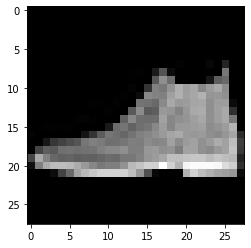

label:  9
prediction:  0
---------------------------- sample:  1


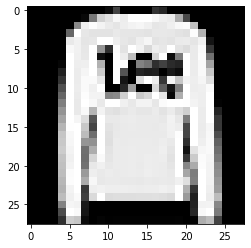

label:  2
prediction:  2
---------------------------- sample:  2


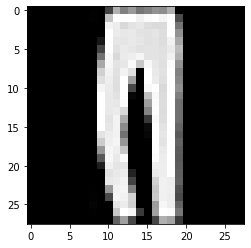

label:  1
prediction:  1
---------------------------- sample:  3


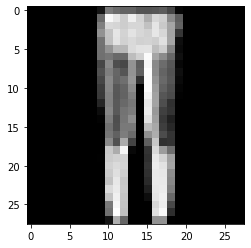

label:  1
prediction:  1
---------------------------- sample:  4


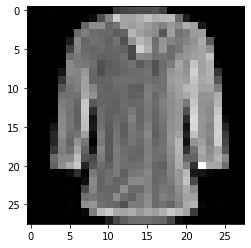

label:  6
prediction:  6
---------------------------- sample:  5


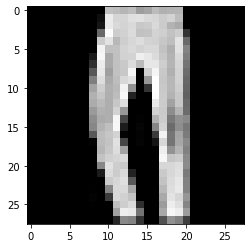

label:  1
prediction:  1
---------------------------- sample:  6


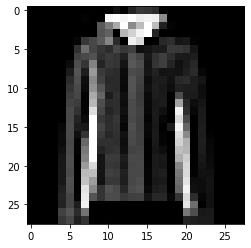

label:  4
prediction:  4
---------------------------- sample:  7


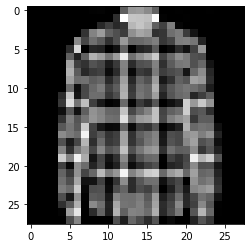

label:  6
prediction:  6
---------------------------- sample:  8


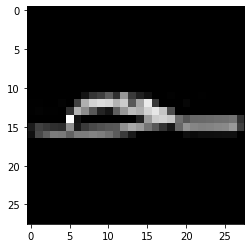

label:  5
prediction:  5


In [ ]:
for i in range(9):
    print('---------------------------- sample: ', i)
    x, y = test_dataset[i]
    plt.imshow(x.squeeze(0), cmap='gray')
    plt.show()
    x = x.view(-1, 784).to(device)
    y = torch.tensor(y)
    pred, _ = model(x,y)
    pred = pred.argmax().item()

    print('label: ', y.item())
    print('prediction: ', pred)

## Model Final Accuracy

In [ ]:
evaluate(model, test_dataloader)

100%|██████████| 1250/1250 [00:02<00:00, 547.52it/s]

val accuracy:  0.7903
val loss: 5466.660635331646


Final accuracy is 88.37%